In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

class travel_data():
    def __init__(self, driving_time, driving_distance, public_transport):
        self.drive_time = driving_time
        self.drive_distance = driving_distance
        self.public_time = public_transport
        
    def driving_distance(self):
        return self.drive_distance
    
    def driving_time(self):
        return self.drive_time
    
    def public_transport_time(self):
        return self.public_time

In [2]:
df = pd.read_pickle("data with distance.pkl")
userdf = pd.read_csv("userDf_new_V2.csv")

stallsdf = df.copy()

In [3]:
def generateRatings(char, placeid):
    global stallsdf
    
    avg = stallsdf.loc[placeid, "Average Review"] # Average Review
    num = stallsdf.loc[placeid, "Number of Reviews"] # Number of Reviews
    shiftedAvg = avg - char * avg
    
    if 10 <= num < 49: #between 25% and 50% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=1), 1) 
            
    elif 49 <= num < 187: #between 50% and 75% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=0.5), 1)
            
    elif num >= 187: #>75% percentile
        value = round(np.random.normal(loc=shiftedAvg, scale=0.25), 1)
    
    else: #below 25% percentile
        value = round(random.uniform(0,5), 1)
        
    if (char >= 0): #Strict - greater variance in review given
        value = round(np.random.normal(loc=value, scale=char*2), 1) #scale will be between 0 and 1
    else:
        value = round(np.random.normal(loc=value, scale=char*-0.5), 1) #0.25 <= scale < 0
    
    if value > 5:
        value = 5.0
    if value < 0:
        value = 0.0   
    
    return value

In [4]:
def update_review(placeid,review_given):
    global stallsdf
    
    current_score = stallsdf.loc[placeid, "Average Review"]
    current_reviewers = stallsdf.loc[placeid, "Number of Reviews"]
    
    total_current_score = current_reviewers * current_score
    
    new_reviewers = current_reviewers + 1
    new_score = (total_current_score + review_given)/new_reviewers
    
    df.loc[placeid, "Average Review"] = new_score
    df.loc[placeid, "Number of Reviews"] = new_reviewers

In [5]:
def df_filter(data, user_address):
    return data[data[f'Travelling from {user_address}'].notna()]

In [6]:
# Get a dataframe of all possible locations a user may visit
def possible_locations_weekday(df, user_address, travel_mode, maximum_travel_time):
    dataframe = df_filter(df, user_address)
    if travel_mode == 1:
        return dataframe.loc[dataframe.loc[:, f"Travelling from {user_address}"].apply(lambda x: float(x.driving_time())) <= maximum_travel_time]
    else:
        return dataframe.loc[dataframe.loc[:, f"Travelling from {user_address}"].apply(lambda x: float(x.public_transport_time())) <= maximum_travel_time]

In [7]:
def possible_locations_weekend(char):
    global stallsdf
    if(char > 0.25):
        return stallsdf.loc[stallsdf["Average Review"] >= 4]
    elif(char <= 0.25):
        return stallsdf.loc[stallsdf["Average Review"] < 4]

In [8]:
# Randomly selects a stall that a person will visit
def selected_stall(possible_choices):
    indexes = possible_choices.index
    return possible_choices.iloc[random.randint(0,len(indexes)-1)]

### Running the Simulation

In [9]:
user_sparse_matrix = pd.read_csv("User Sparse Matrix.csv")
user_sparse_matrix

,UserId,StallId,Rating
0,0,12029,4.9
1,2,13862,4.0
2,3,5251,4.0
3,4,6612,4.6
4,5,15110,5.0
...,...,...,...
283819,1994,1489,5.0
283820,1995,10008,1.5
283821,1996,12822,4.1
283822,1998,13749,4.8


In [10]:
no_dups = user_sparse_matrix.drop_duplicates(subset = ["UserId", "StallId"], keep = False)

In [11]:
duplicates = user_sparse_matrix[user_sparse_matrix.duplicated(subset = ["UserId", "StallId"], keep = False)].sort_values(by = ["UserId", "StallId"], ignore_index = True)

In [12]:
duplicates

,UserId,StallId,Rating
0,1,14355,2.8
1,1,14355,1.1
2,2,9936,2.4
3,2,9936,2.2
4,4,1960,2.8
...,...,...,...
4490,1998,18142,3.2
4491,1999,18276,0.4
4492,1999,18276,2.3
4493,1999,18621,1.8


In [13]:
index_ = (duplicates.groupby(["UserId", "StallId"]).mean().index)
values_ = (duplicates.groupby(["UserId", "StallId"]).mean().values)

In [14]:
merged_dups = []

In [15]:
for i in range(len(index_)):
    merged_dups.append([index_[i][0], index_[i][1], values_[i,0]])

In [16]:
merged_dups

[[1, 14355, 1.95],
 [2, 9936, 2.3],
 [4, 1960, 3.4499999999999997],
 [4, 5125, 4.8],
 [4, 8745, 2.6500000000000004],
 [4, 9040, 4.55],
 [4, 12446, 2.75],
 [4, 16176, 4.65],
 [7, 16200, 4.6],
 [7, 18864, 5.0],
 [7, 20616, 5.0],
 [13, 102, 2.9],
 [13, 605, 3.65],
 [13, 7080, 4.199999999999999],
 [13, 7145, 3.35],
 [13, 14718, 3.7],
 [13, 18017, 4.35],
 [15, 11553, 2.0],
 [15, 18875, 3.2],
 [18, 18592, 4.449999999999999],
 [18, 20270, 2.5],
 [19, 13743, 2.25],
 [20, 13503, 5.0],
 [21, 1183, 5.0],
 [21, 1340, 2.05],
 [21, 3896, 1.0999999999999999],
 [21, 5586, 1.2],
 [21, 7001, 3.75],
 [21, 17632, 4.75],
 [23, 4011, 3.95],
 [24, 4650, 2.65],
 [24, 6414, 3.05],
 [25, 774, 4.4],
 [25, 914, 5.0],
 [26, 20587, 1.65],
 [27, 1255, 4.65],
 [27, 3489, 3.25],
 [27, 12280, 1.85],
 [28, 4062, 4.5],
 [28, 4204, 2.8],
 [30, 14697, 2.6],
 [31, 11380, 3.15],
 [31, 19397, 3.85],
 [31, 19800, 2.75],
 [35, 4601, 1.05],
 [38, 1267, 3.6999999999999997],
 [40, 6315, 1.9500000000000002],
 [40, 20846, 4.6],
 [42

In [17]:
df8 = pd.DataFrame(data = merged_dups, columns = ["UserId", "StallId", "Rating"])

In [18]:
user_sparse_matrix_no_dups = pd.concat([no_dups, df8])

In [19]:
reviews = pd.read_csv("User Reviews Final.csv")

In [20]:
reviewCounts = list(reviews.UserId.value_counts())

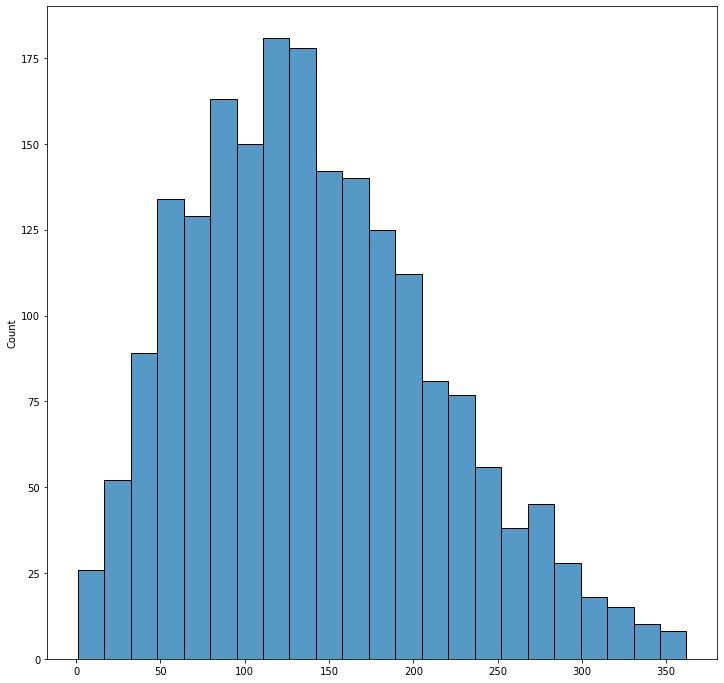

In [21]:
f = plt.figure(figsize=(12,12))
sb.histplot(reviewCounts)
plt.show()

/Users/jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


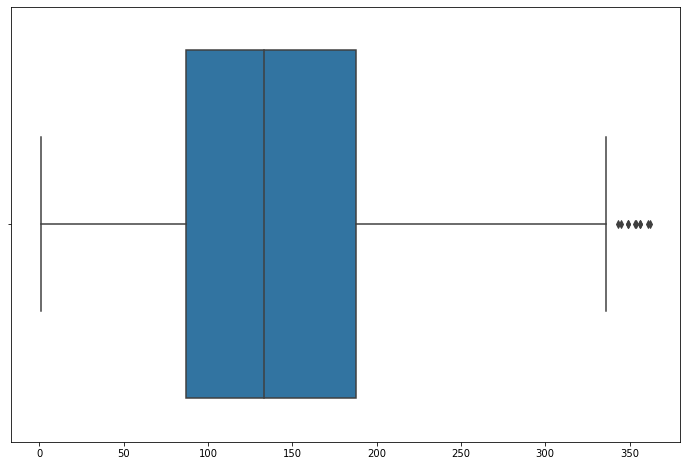

In [22]:
f = plt.figure(figsize = (12,8))
sb.boxplot(reviewCounts)
plt.show()

In [23]:
sum(reviewCounts)/len(reviewCounts)

140.9949924887331

In [24]:
import scipy.stats as sc
q1, q3 = np.percentile(reviewCounts,[25,75])
iqr = sc.iqr(reviewCounts)
upper_bound = q3 + (1.5 * iqr) 
lst1 = list(reviews.UserId.value_counts())
lst2 = list(filter(lambda x: x > upper_bound,lst1))
lst2

[362, 361, 356, 356, 354, 353, 349, 349, 345, 343]

Hence, on average, each of our user will rate 140 restarants in a year, with 10 outliers, who voted more than 343 times.